# GPU-Accelerated Ideal Gas Law Simulation

Source video: https://www.youtube.com/watch?v=2XckqFzUiYU

Source code: https://github.com/lukepolson/youtube_channel/blob/main/Python%20GPU/boltzmann_part2.ipynb

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
n_particles = 16
radius = 0.06
r = torch.rand((2,n_particles)).to(device)

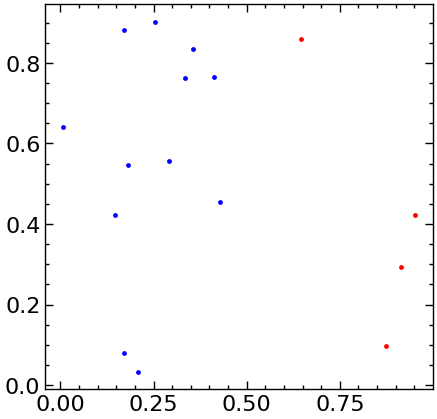

In [3]:
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

In [4]:
# We assign each of the initial velocities to be +500m/s (blue) or -500m/s (red)
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

# By assigning each particle a unique ID, we can track the distance between all pairs:
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)

In [5]:
# Compute all the distances and deltas
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)

In [6]:
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]

In [7]:
# Change all velocities at the same time
# NOTE TO SELF: Undestand this.

v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

In [8]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, ids_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = ids_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = r
    return rs, vs

In [9]:
N = 30
dt = 8e-6
t_steps = 2000
v0 = 500
L = 1
r = torch.rand((2,N)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(N)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,N)).to(device)
v[0][ixr] = -v0
v[0][ixl] = v0
radius = 0.005
rs, vs = motion(r, v, ids_pairs, ts=t_steps, dt=dt, d_cutoff=2*radius)

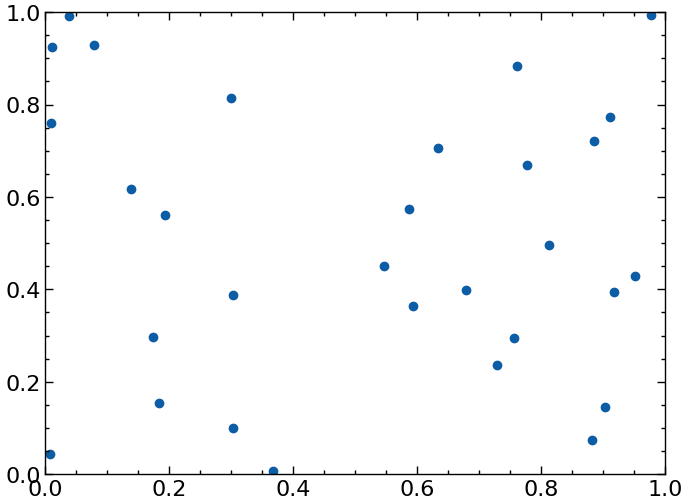

In [10]:
plt.scatter(*rs[482].cpu())
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

# Ideal Gas Law

In [11]:
# 3D Code

def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    dz = torch.diff(torch.stack([r[2][ids_pairs[:,0]], r[2][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2 + dz**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, L, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, *r.shape)).to(device)
    vs = torch.zeros((ts, *v.shape)).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    dv = torch.zeros(ts).to(device)
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, id_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        # NEW STUFF
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>L])
        dv[i] += 2*torch.sum(torch.abs(v[0,r[0]>L]))
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        dv[i] += 2*torch.sum(torch.abs(v[0,r[0]<0]))
        v[1,r[1]>L] = -torch.abs(v[1,r[1]>L])
        dv[i] += 2*torch.sum(torch.abs(v[1,r[1]>L]))
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        dv[i] += 2*torch.sum(torch.abs(v[1,r[1]<0]))
        v[2,r[2]>L] = -torch.abs(v[2,r[2]>L])
        dv[i] += 2*torch.sum(torch.abs(v[2,r[2]>L]))
        v[2,r[2]<0] = torch.abs(v[2,r[2]<0])
        dv[i] += 2*torch.sum(torch.abs(v[2,r[2]<0]))
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs, dv

In [12]:
N = 3000
dt = 8e-6
t_steps = 2000
t = np.arange(t_steps)*dt
v0 = 500
L = 1
r = torch.rand((3,N)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(N)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((3,N)).to(device)
v[0][ixr] = -v0
v[0][ixl] = v0
radius = 0.005
rs, vs, dv = motion(r, v, L, ids_pairs, ts=t_steps, dt=dt, d_cutoff=2*radius)

Text(0, 0.5, '$\\Delta v_i$ [m/s]')

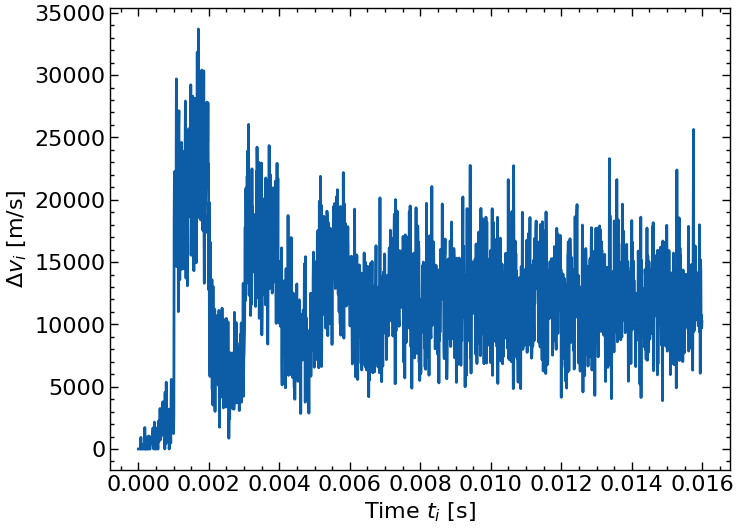

In [13]:
plt.plot(t, dv.cpu())
plt.xlabel(r'Time $t_i$ [s]')
plt.ylabel(r'$\Delta v_i$ [m/s]')

In [14]:
def run_simulation(N, v0, L, radius=0.005, n_points = 1000, t_steps=4000):
    dt = 8e-6
    r = torch.rand((3,N)).to(device)
    ixr = r[0]>0.5 
    ixl = r[0]<=0.5 
    ids = torch.arange(N)
    ids_pairs = torch.combinations(ids,2).to(device)
    v = torch.zeros((3,N)).to(device)
    v[0][ixr] = -v0
    v[0][ixl] = v0
    rs, vs, dv = motion(r, v, L, ids_pairs, ts=t_steps, dt=dt, d_cutoff=2*radius)
    LHS = torch.sum(dv[-n_points:]) / (6 * L**2 * dt * n_points)
    RHS = N / 3 * v0**2
    return LHS.item(), RHS

In [15]:
v0s = [300, 500, 700, 900]
LHSs = []
RHSs = []
for v0 in v0s:
    LHS, RHS = run_simulation(N=3000, v0=v0, L=1)
    LHSs.append(LHS)
    RHSs.append(RHS)

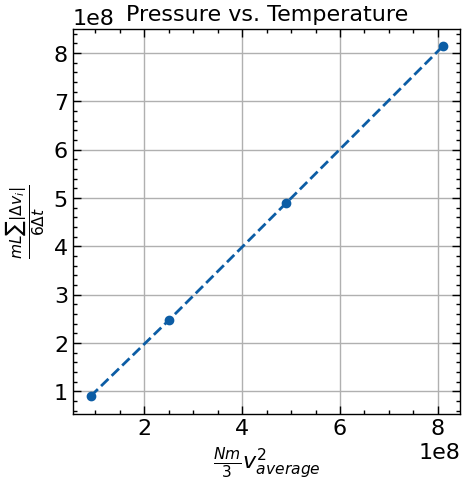

In [16]:
plt.figure(figsize=(5,5))
plt.plot(RHSs, LHSs, 'o--')
plt.title('Pressure vs. Temperature')
plt.xlabel(r'$\frac{Nm}{3}v_{average}^2$')
plt.ylabel(r'$\frac{mL \sum |\Delta v_i|}{6 \Delta t}$')
plt.grid()
plt.show()